<h1> Advantage Actor Critic on continuous actions </h1>


<h3> Import dependencies </h3>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium
from tqdm import tqdm
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import torch
from torch import nn
import cloudpickle
import sklearn
from sklearn import preprocessing
torch.set_grad_enabled(True) 

<h3> Helper functions </h3>

In [ ]:
def get_grads(model:torch.nn.Module):
    g = [param.grad.flatten() for param in model.parameters() if param.grad is not None]
    g = torch.cat(g).norm()
    # if g > 100:
    #     print("High gradient")
    return g
def dump():
    with (open("./models/actor.pkl","wb") as f1, 
          open("./models/critic.pkl","wb") as f2, 
          open("./models/scaler.pkl","wb") as f3):
        cloudpickle.dump(actor,f1)
        cloudpickle.dump(critic,f2)
        cloudpickle.dump(scaler,f3)
def load():
    with (open("./models/actor.pkl","rb") as f1, 
          open("./models/critic.pkl","rb") as f2, 
          open("./models/scaler.pkl","rb") as f3):
        actor = cloudpickle.load(f1)
        critic = cloudpickle.load(f2)
        scaler = cloudpickle.load(f3)
        return actor,critic,scaler

<h3> Actor critic helper classes </h3>

In [153]:
class Actor:
    def __init__(self):
        self.pi = nn.Sequential(nn.Linear(2,50),
                  nn.ReLU(),
                  nn.Linear(50,2))
    def log_prob(self,state,action):
        dist =self._get_dist(state)
        return dist.log_prob(action),dist.entropy()
    
    def sample(self,state):
        dist =self._get_dist(state)
        _sample = dist.sample((1,))
        return _sample
    
    def _get_dist(self,state):
        mu,sigma = self.pi(state)
        sigma = torch.nn.Softplus()(sigma) + 1e-5
        dist = torch.distributions.Normal(mu,sigma)
        return dist

class Critic:
    def __init__(self):
        self.v = nn.Sequential(nn.Linear(2,100),
                  nn.ReLU(),
                  nn.Linear(100,1))
    
    def val(self,state):
        _val = self.v(state)
        return _val
    

<h3> Implementation of A2C </h3>

In [226]:
NUM_TRIALS = 1
NUM_EPISODES = 1000
ALPHA_V = 1e-8
ALPHA_PI = 1e-8
GAMMA = 1
env = gymnasium.make("MountainCarContinuous-v0")
returns = np.zeros((NUM_TRIALS,NUM_EPISODES))
ep_lens = np.zeros((NUM_TRIALS,NUM_EPISODES))
grads = [[],[]]
losses = [[],[]]
entropies = []
rewards = []
for i in range(NUM_TRIALS):
    actor = Actor()
    critic = Critic()
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(np.array([env.observation_space.sample() for _ in range(10000)]))
    mse_loss = nn.MSELoss()
    pi_op = torch.optim.SGD(actor.pi.parameters(),lr=ALPHA_PI)
    v_op = torch.optim.SGD(critic.v.parameters(),lr=ALPHA_V)
    for j in range(NUM_EPISODES):
        ret = 0.
        ep_len=0.
        state,*_ = env.reset()
        state = np.squeeze(scaler.transform([state]))
        while True:
            with torch.no_grad():
                state = torch.as_tensor(state).float()
                action = actor.sample(state)
                action = torch.clamp(action,env.action_space.low[0],env.action_space.high[0])
            next_state,reward,terminated,truncated,*_ = env.step(action)
            ret+=reward
            rewards.append(reward)
            reward-= np.mean(rewards)
            reward/= (np.std(rewards)+1e-3)
            ep_len+=1
            if terminated:
                print("Achieved target in",ep_len,"steps at ep",j,"with ret",ret)
            next_state = np.squeeze(scaler.transform([next_state]))
            with torch.no_grad():
                next_state = torch.from_numpy(next_state).float()
                target = torch.tensor([reward],dtype=torch.float) + GAMMA * (critic.val(next_state) if not terminated else 0)
            v_op.zero_grad()
            est_v = critic.val(state)
            loss = mse_loss(target,est_v)
            loss.backward()
            v_op.step()
            with torch.no_grad():
                losses[0].append(loss.item())
                grads[0].append(get_grads(critic.v))
                critic_est = torch.tensor([reward],dtype=torch.float)  + GAMMA*(critic.val(next_state) if not terminated else 0) - critic.val(state)
            pi_op.zero_grad()
            prob = actor.log_prob(state,action)
            # if prob[1] <0.5:
            #     loss = (GAMMA**ep_len)*critic_est*prob[0]*-1 + (-1*prob[1]) 
            # else:
            #     loss = (GAMMA**ep_len)*critic_est*prob[0]*-1 + (prob[1]) #The -1 is needed coz pytorch always does SGD and not ascent
            loss = critic_est*prob[0]*-1 + (-0.8*prob[1]) 
            loss.backward()
            pi_op.step()
            with torch.no_grad():
                losses[1].append(loss.item())
                grads[1].append(get_grads(actor.pi))
                entropies.append(prob[1].numpy())
                if prob[0].numpy() < -1e2 or prob[1].numpy() < -10:
                    ;
            state = next_state
            if terminated or truncated:
                break
        returns[i,j] = ret
        ep_lens[i,j] = ep_len
        

KeyboardInterrupt: 

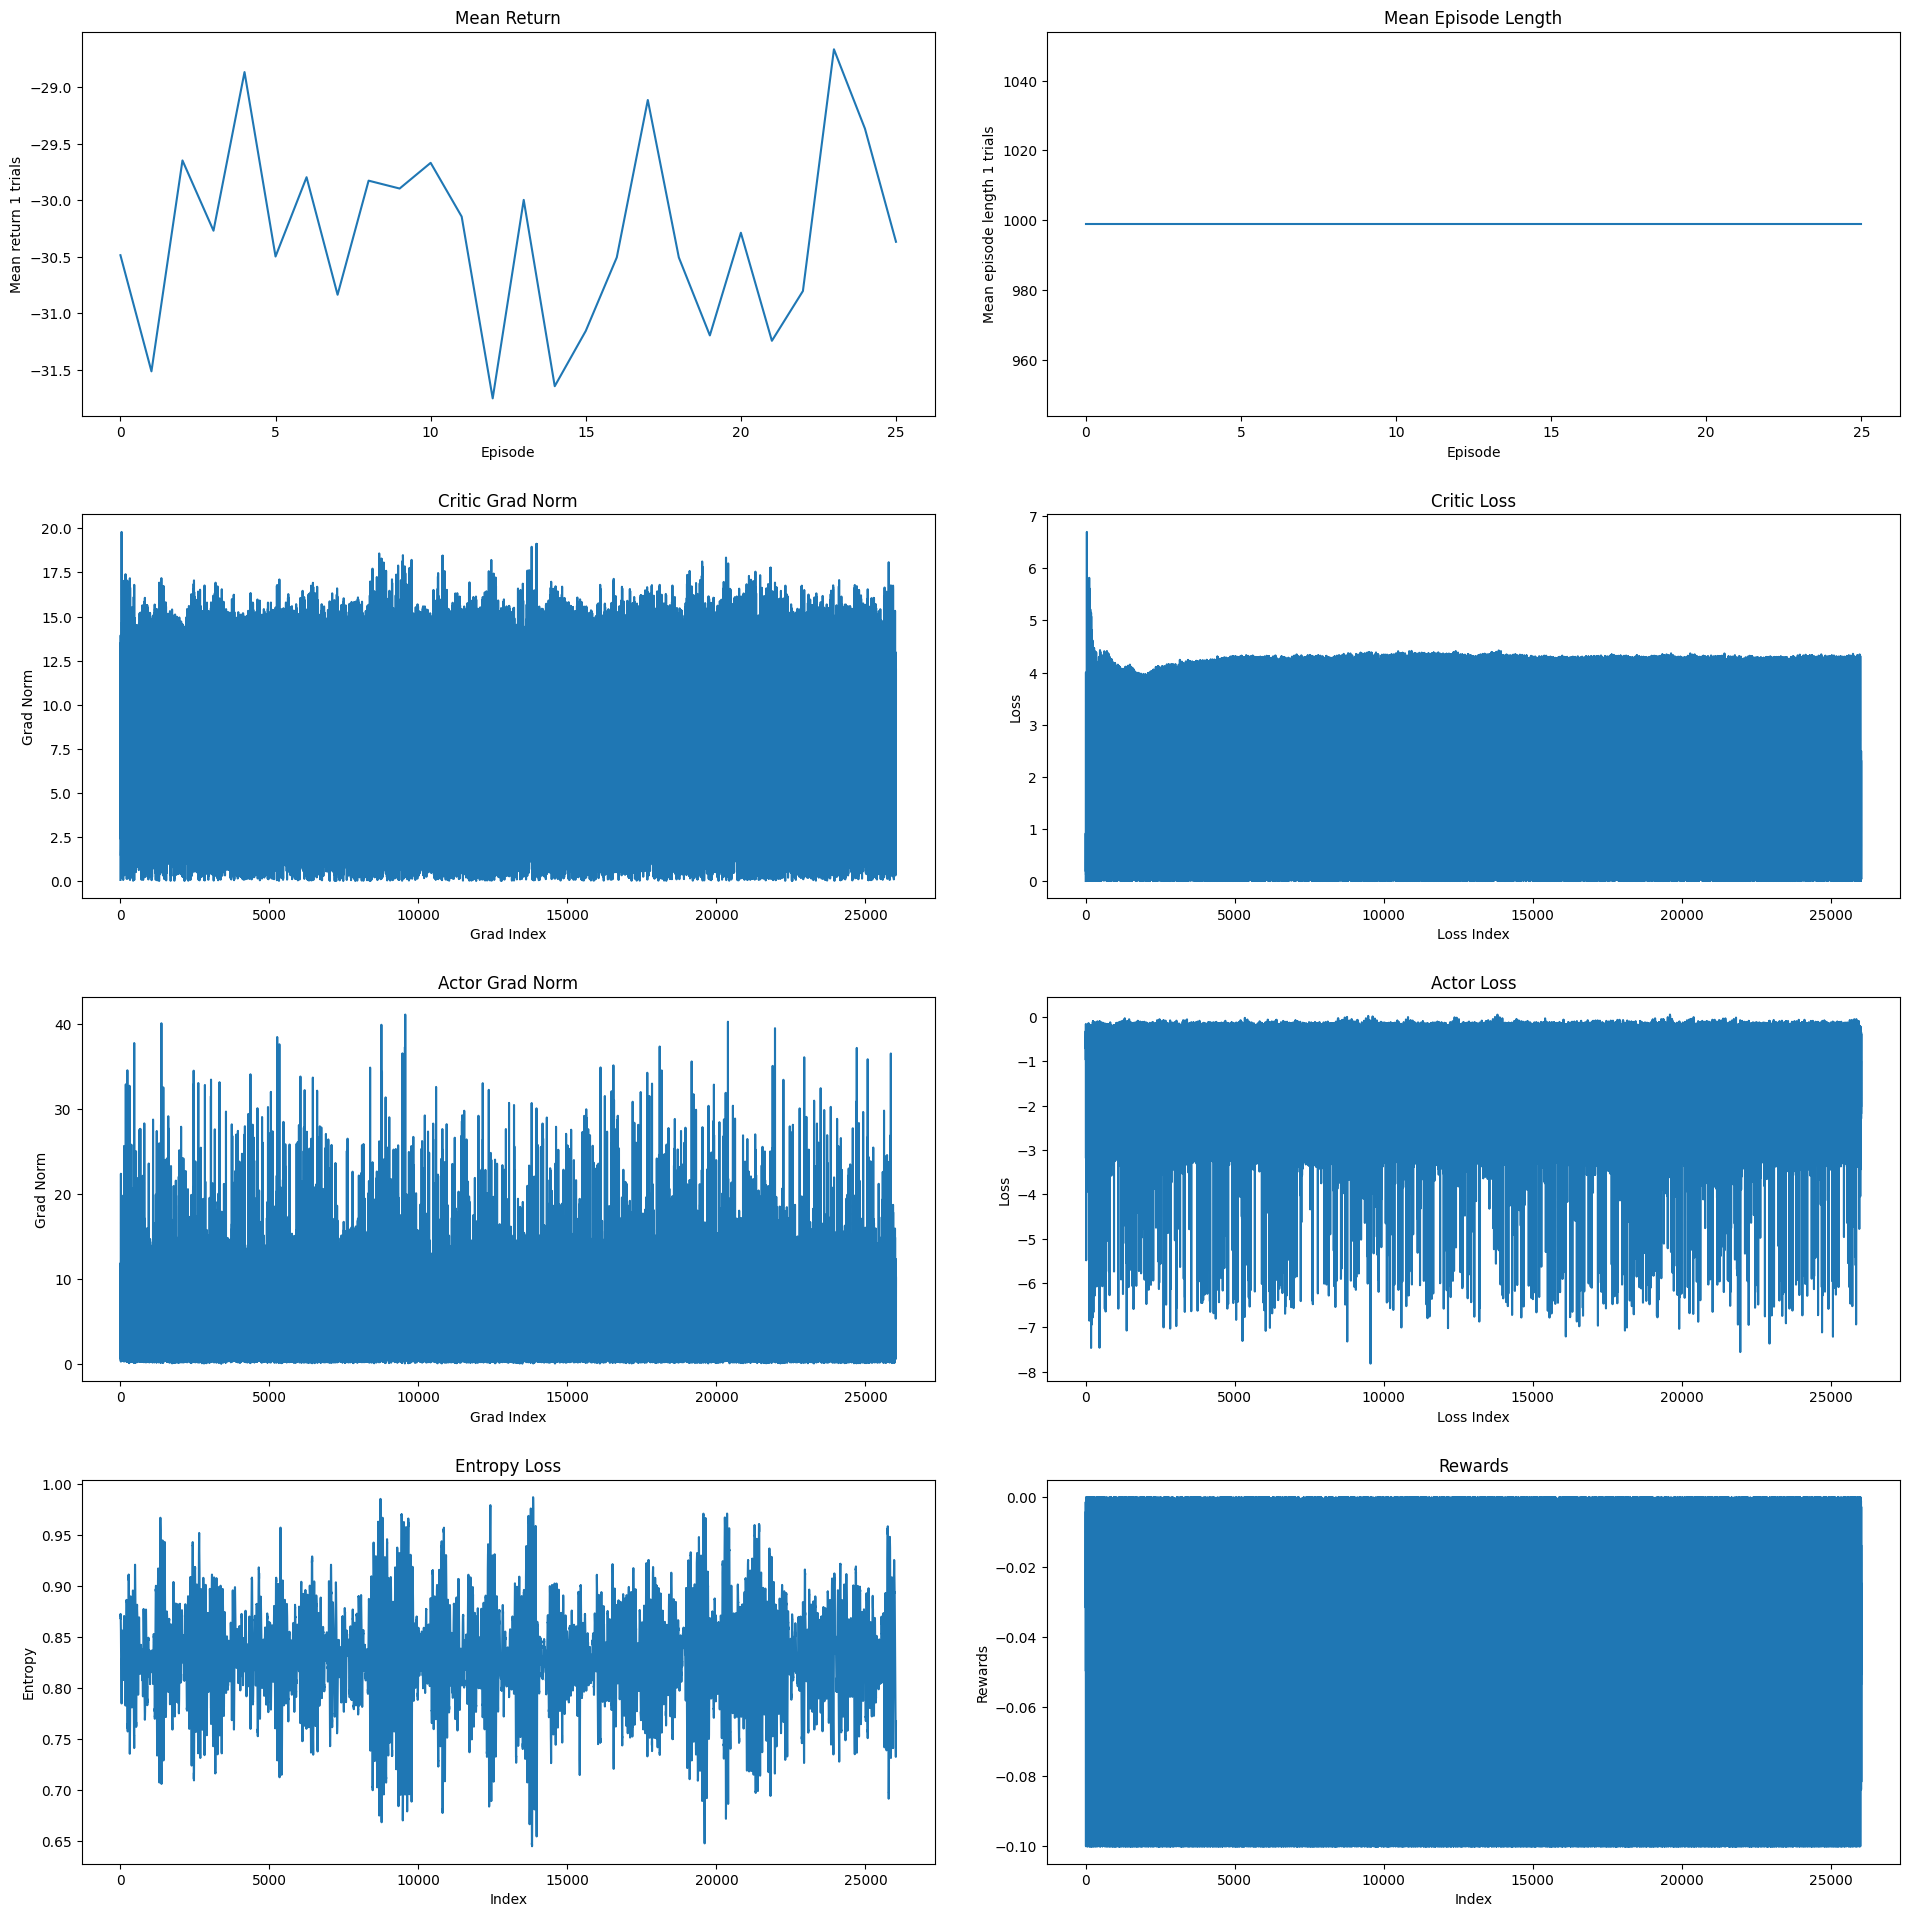

In [227]:
fig:Figure
ax1:Axes
ax2:Axes
ax3:Axes
ax4:Axes
ax5:Axes
ax6:Axes
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(4,2)
fig.set_figwidth(20)
fig.set_figheight(20)
fig.tight_layout(pad=5.0)
ax1.plot(returns[0][:j])
ax1.set_ylabel(f"Mean return {NUM_TRIALS} trials")
ax1.set_xlabel("Episode")
ax1.set_title("Mean Return")
ax2.plot(ep_lens[0][:j])
ax2.set_ylabel(f"Mean episode length {NUM_TRIALS} trials")
ax2.set_xlabel("Episode")
ax2.set_title("Mean Episode Length")
ax3.plot(grads[0])
ax3.set_ylabel(f"Grad Norm")
ax3.set_xlabel("Grad Index")
ax3.set_title("Critic Grad Norm")
ax4.plot(losses[0])
ax4.set_ylabel(f"Loss")
ax4.set_xlabel("Loss Index")
ax4.set_title("Critic Loss")
ax5.plot(grads[1])
ax5.set_ylabel(f"Grad Norm")
ax5.set_xlabel("Grad Index")
ax5.set_title("Actor Grad Norm")
ax6.plot(losses[1])
ax6.set_ylabel(f"Loss")
ax6.set_xlabel("Loss Index")
ax6.set_title("Actor Loss");
ax7.plot(entropies)
ax7.set_ylabel(f"Entropy")
ax7.set_xlabel("Index")
ax7.set_title("Entropy Loss");
ax8.plot(rewards)
ax8.set_ylabel(f"Rewards")
ax8.set_xlabel("Index")
ax8.set_title("Rewards");

In [94]:
list(critic.v.parameters())[0]

Parameter containing:
tensor([[ 0.0170, -0.3536],
        [ 0.3765, -0.0308],
        [-0.1202,  0.0634],
        [-0.1147,  0.5632],
        [ 0.4679,  0.7185],
        [-0.3931, -0.0193],
        [ 0.6710,  0.4738],
        [-0.6221, -0.1654],
        [ 0.3478, -0.4402],
        [ 0.4858,  0.1475],
        [ 0.4861,  0.5490],
        [ 0.0160, -0.7003],
        [-0.3228, -0.3311],
        [ 0.1920, -0.3775],
        [ 0.1557, -0.2768],
        [-0.1415, -0.6491],
        [-0.4797,  0.4564],
        [-0.3389, -0.4914],
        [ 0.5847, -0.4400],
        [-0.0196,  0.0667],
        [-0.4623,  0.2107],
        [ 0.1048, -0.1164],
        [ 0.1855,  0.6349],
        [ 0.6552,  0.6311],
        [-0.4265, -0.2800],
        [-0.3930,  0.3420],
        [-0.1668, -0.0240],
        [-0.4979,  0.4045],
        [ 0.5641, -0.5419],
        [-0.6499, -0.2693],
        [ 0.4802, -0.4678],
        [ 0.0136,  0.5883],
        [ 0.6884,  0.1008],
        [ 0.3661,  0.3697],
        [-0.3158, -0.5942]

In [95]:
list(actor.pi.parameters())[0]

Parameter containing:
tensor([[ 0.6730,  0.0235],
        [ 0.5826,  0.2502],
        [-0.4786, -0.2359],
        [-0.7292, -0.4583],
        [-0.3929, -0.6038],
        [ 0.2785, -0.6458],
        [ 0.3347,  0.6314],
        [-0.5889,  0.2896],
        [ 0.0248, -0.1333],
        [ 0.5331,  0.4967],
        [ 0.6393, -0.5482],
        [ 0.6289, -0.6651],
        [-0.3596, -0.0337],
        [ 0.1112,  0.0882],
        [-0.4363,  0.5052],
        [-0.3925,  0.1687],
        [-0.6776, -0.0045],
        [ 0.3933, -0.2848],
        [-0.0172,  0.6272],
        [-0.4658,  0.4183],
        [-0.1240,  0.2765],
        [-0.0447,  0.0733],
        [ 0.0017,  0.1106],
        [ 0.1813,  0.0415],
        [ 0.3407, -0.4824],
        [ 0.1779,  0.6081],
        [-0.2493,  0.5540],
        [-0.1403,  0.2426],
        [-0.4452,  0.3051],
        [ 0.3234, -0.7243],
        [-0.0985,  0.1869],
        [ 0.3854,  0.4014],
        [ 0.4101, -0.1825],
        [-0.0750,  0.5756],
        [ 0.1608, -0.6778]

In [222]:
returns[:,:j]

True True True


In [219]:
dump()

<h3> Evaluate in human render mode </h3>

In [98]:
actor,critic,scaler = load()
env = gymnasium.make("MountainCarContinuous-v0",render_mode="human")
for _ in range(10):
    state,*_ = env.reset()
    while True:
        state = np.squeeze(scaler.transform([state]))
        state = torch.from_numpy(state).detach().float()
        with torch.no_grad():
            action = actor.sample(state)
        next_state,reward,terminated,truncated,*_ = env.step(action)
        if terminated or terminated:
            break
        state = next_state